In [14]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from PIL import Image
import time
import os

log_paths = ["../logs/log2021-03-10_01-24-20/", "../logs/log2021-03-10_00-43-20/"]
log_labels = ["Flat prior", "Last window posterior"]

# data_path = open("data_path.txt", "r").read()
# df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [2]:
locations = open(r"init_modelsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SIR"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['SIR 0.02 1 0.03 0.9 0.08 0.02']
['SIR']


In [3]:
# data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])

In [5]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

4


In [6]:
location = locations[0].split(" ")[0]

days_sets = sorted(os.listdir(log_paths[0]+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-1]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [20]:
rmsd_train = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_val= [np.zeros((len(models), n_days)) for i in range(len(log_paths))]
rmsd_total = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

trials = [np.zeros((len(models), n_days)) for i in range(len(log_paths))]

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(log_paths)):
        
        params.append(np.zeros((n_days, model.nparams)))
        
        path = log_paths[i]+"Posterior%i/%s/%s/" % (n_post, location, models[model_idx])

        for days_idx in range(len(days_sets)):

            params[-1][days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")

            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]

            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line

                if ("Number of trials" in log_file[line]):

                    trials[i][model_idx, days_idx] = int(log_file[line].split(" ")[-1])

            rmsd_train[i][model_idx, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[i][model_idx, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[i][model_idx, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

In [10]:
plt.rcParams.update({'font.size': 22})

def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

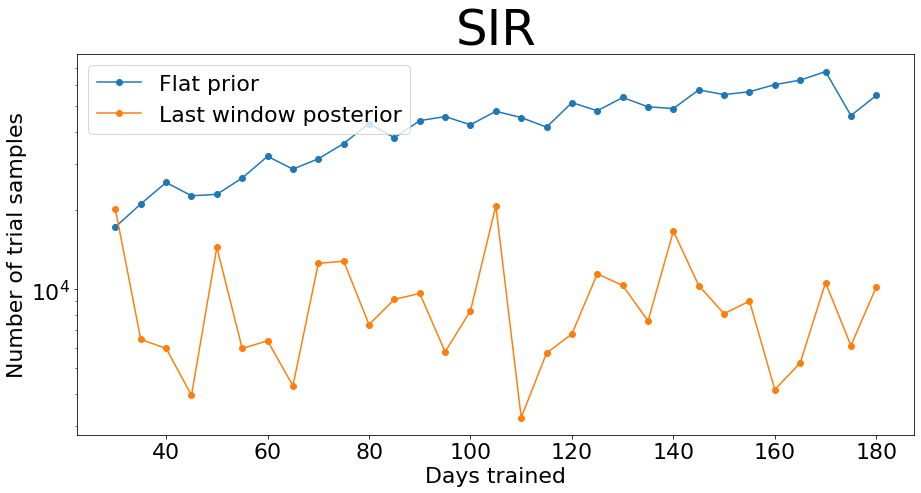

In [15]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
        
    for j in range(len(trials)):
            
        plt.plot(days, trials[j][model_idx], "-o", label=log_labels[j])
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel("Number of trial samples")
        plt.yscale("log")
        plt.title(model.plot_name, fontsize=50)
            
    plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

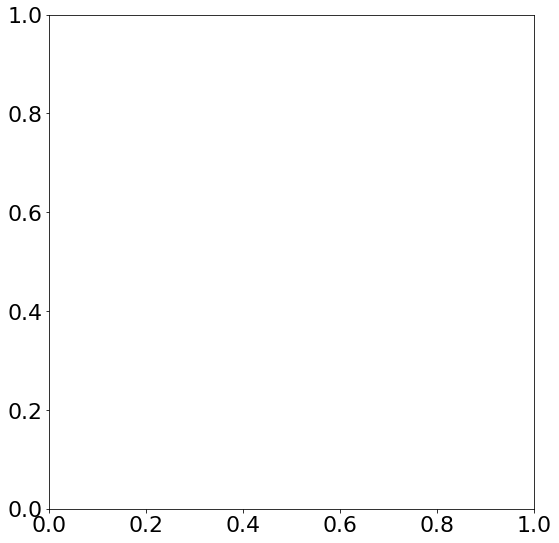

In [12]:
for p in range(len(params)):
    
    model = getattr(epi_mod, models[p])
    
    plt.figure(figsize=(10*best_rows_cols(params[p].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    
    for i in range(params[p].shape[-1]):

        plt.subplot(*best_rows_cols(params[p].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
        for j in range(params[p].shape[0]):
            plt.plot(days, params[p][j,:,i], "-o", label="Posterior %i"%(j+1))
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):
            
            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")
    
    plt.suptitle(model.plot_name, fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

In [22]:
rmsd_train = np.zeros((len(models), n_post, n_days))
rmsd_val= np.zeros((len(models), n_post, n_days))
rmsd_total = np.zeros((len(models), n_post, n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    params.append(np.zeros((n_post, n_days, model.nparams)))
        
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            params[-1][post-1,days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line
            
            rmsd_train[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

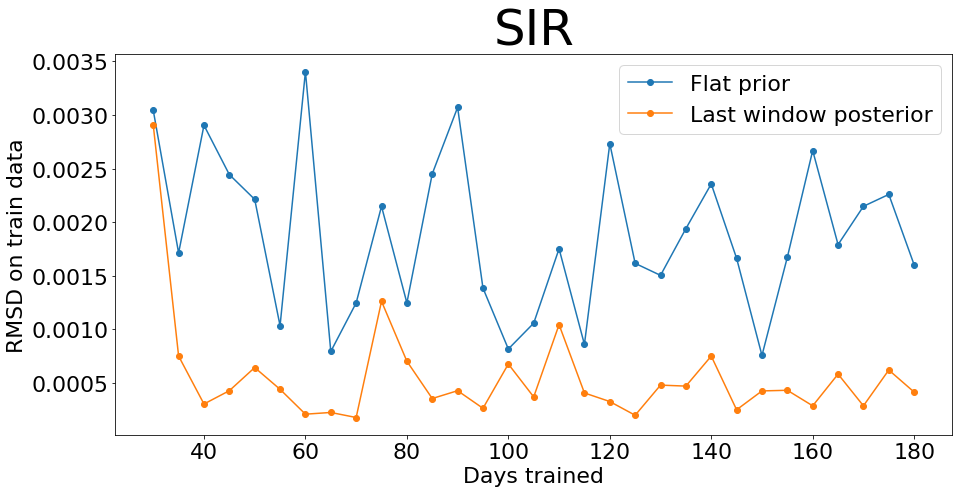

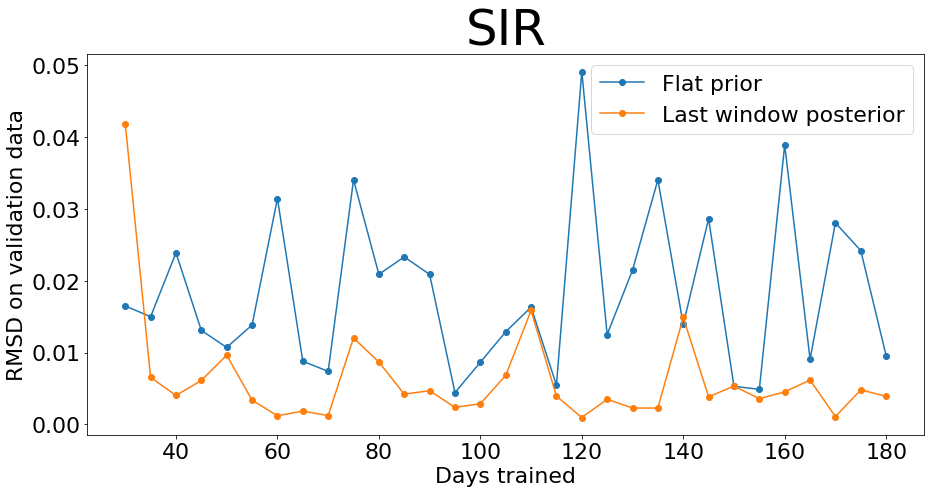

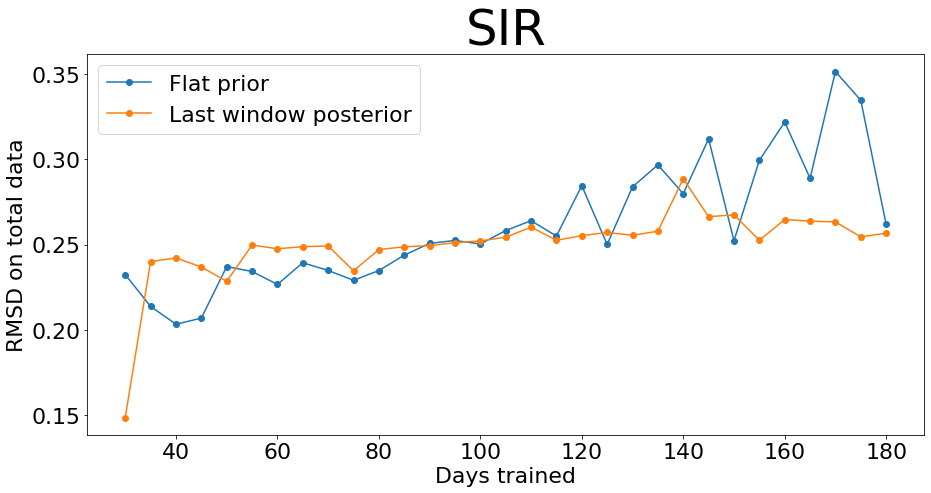

In [34]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        
        for j in range(len(rmsd[i])):
            
            plt.plot(days, rmsd[i][j][model_idx], "-o", label=log_labels[j])
            plt.legend()
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.title(model.plot_name, fontsize=50)
            
    plt.show()

In [32]:
rmsd[i]

[array([[0.003045, 0.001714, 0.002905, 0.002445, 0.002214, 0.001035,
         0.003406, 0.000795, 0.001248, 0.002149, 0.001248, 0.002452,
         0.003072, 0.001386, 0.000818, 0.001059, 0.001753, 0.000861,
         0.002734, 0.001617, 0.001505, 0.001941, 0.002358, 0.001664,
         0.000758, 0.001674, 0.002669, 0.001792, 0.002149, 0.00226 ,
         0.001603]]),
 array([[0.002908, 0.000752, 0.000305, 0.000429, 0.000645, 0.000442,
         0.00021 , 0.000226, 0.000179, 0.001263, 0.000704, 0.000356,
         0.000429, 0.000265, 0.000678, 0.000371, 0.001045, 0.000408,
         0.000328, 0.0002  , 0.000481, 0.000472, 0.000752, 0.000251,
         0.000427, 0.000433, 0.000288, 0.000584, 0.000288, 0.000622,
         0.000416]])]

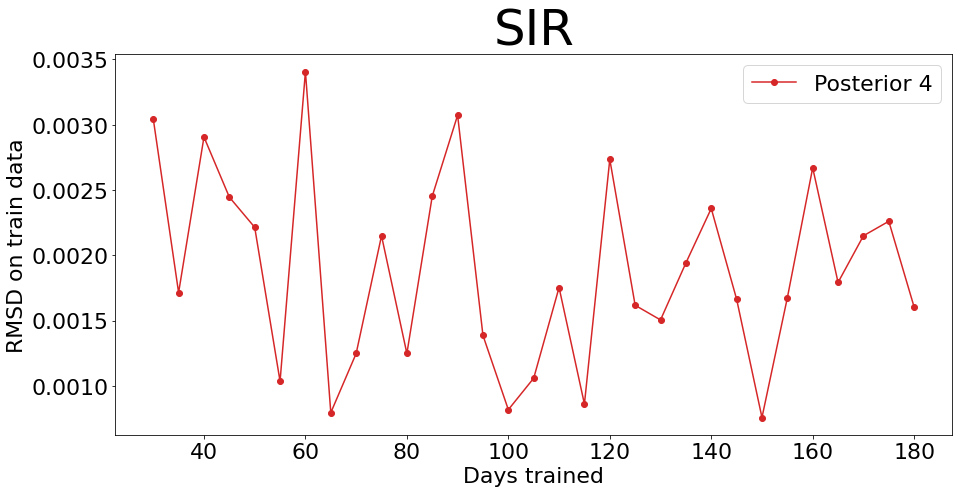

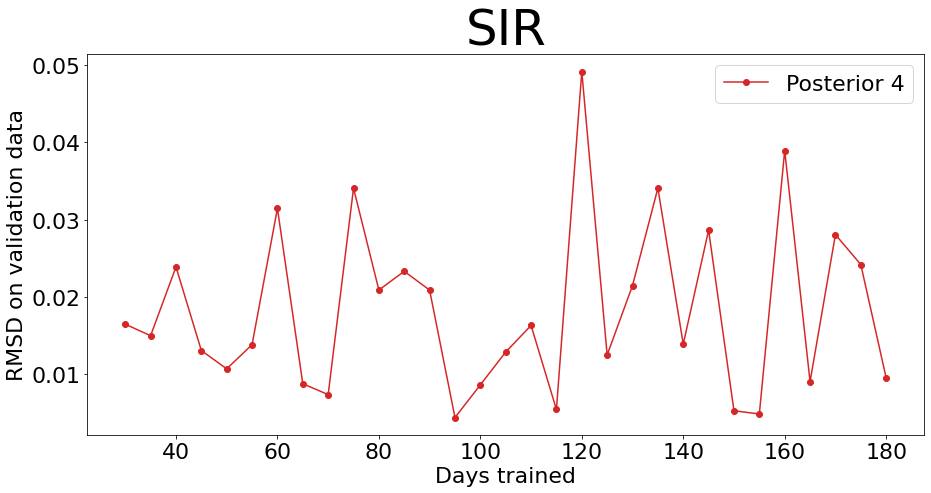

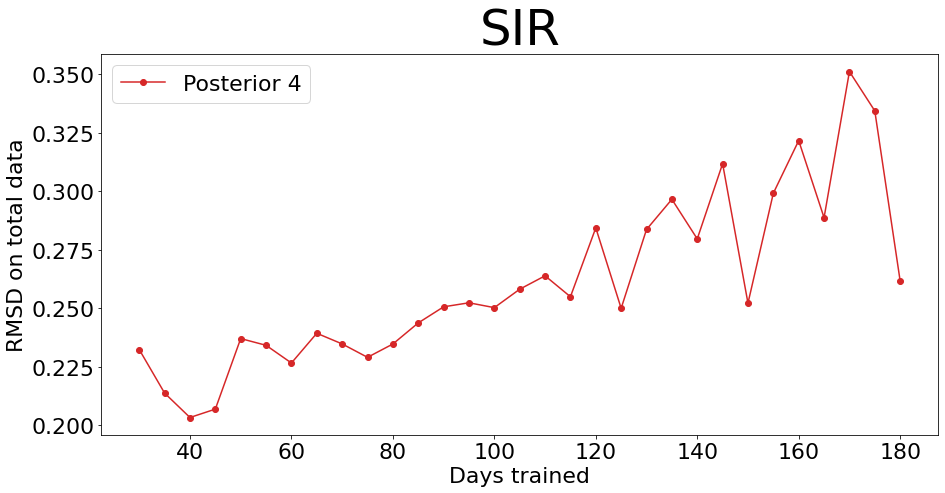

In [24]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        plt.plot(days, rmsd[i][model_idx, j], "-o", c="C%s"%(rmsd[i].shape[1]-1), label="Posterior %i"%(j+1))
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel(rmsd_names[i])
        plt.title(model.plot_name, fontsize=50)
        
    plt.show()

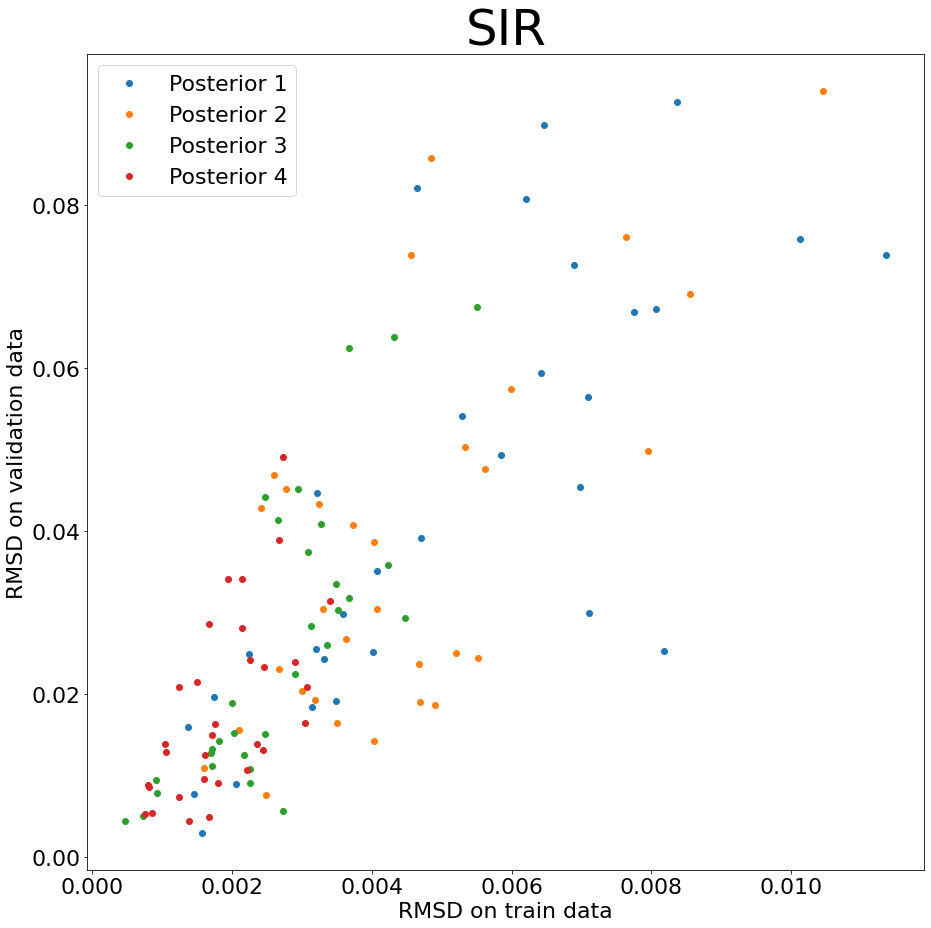

In [25]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,15))

    for j in range(rmsd[0].shape[1]):
        
        plt.plot(rmsd[0][model_idx, j], rmsd[1][model_idx, j], "o", label="Posterior %i"%(j+1))
        plt.legend()
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.title(model.plot_name, fontsize=50)
    plt.show()

In [26]:
from scipy.stats import pearsonr

print("RMSD on train and validation Pearson Correlations:")
for i in range(0, n_post):
    print("Posterior %i:"%(i+1), pearsonr(rmsd[0][0,i], rmsd[1][0,i]))

RMSD on train and validation Pearson Correlations:
Posterior 1: (0.754544450641833, 9.424316667294654e-07)
Posterior 2: (0.6721672858106841, 3.45434722091752e-05)
Posterior 3: (0.7970544697102473, 8.052457173608327e-08)
Posterior 4: (0.6012374927652742, 0.0003474017727724913)
